# Denoising with Neural Networks
Beside classical algorithms, e.g. Wiener Filter, it is possible to use Artificial Neural Networks (ANN) for denoising.
The algorithms are trained on the log-mel-spectrogram, in order to decrease the number of relevant frequency bins (by applying the mel filterbank) and in order to decrease the range of input values (by applying the logarithm).

In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import os
os.chdir('../Python')
import TrainingsDataInterface
import Constants
import RTISI
import WaveInterface

TempFolder = "NeuralNetworks/DenoisingData"
FilenameData = TempFolder + '/Data.npz'
try:
    os.mkdir(TempFolder)
except:
    pass

r = Constants.theConstants.getSamplingFrequencyMicrofone()
TimeMemoryOfInput = 5

## Logarithmic frequency scaling
The following algorithms transform the linear frequency axis from the FFT into a logarithmic frequency axis.

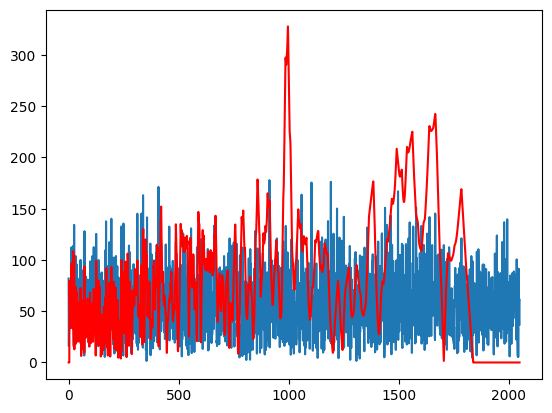

In [2]:
def Bark2KiloHertz(b):
    return 1.96 * (b + 0.53) / (26.28 - b)

def MelFilterBank(NumberOfCenterFrequenciesPerBark, NumberOfInputFrequencyBins, SamplingRate):
    FFTLen = 2 * NumberOfInputFrequencyBins - 2
    Deltaf = SamplingRate / FFTLen
    f = np.arange(NumberOfInputFrequencyBins) * Deltaf
    CutoffFrequenciesInBark = np.arange(24*NumberOfCenterFrequenciesPerBark+1) / NumberOfCenterFrequenciesPerBark
    CutoffFrequenciesInHertz = Bark2KiloHertz(CutoffFrequenciesInBark) * 1000
    CenterFrequenciesInHertz = np.diff(CutoffFrequenciesInHertz) / 2
    CenterFrequenciesInHertz += CutoffFrequenciesInHertz[0:CutoffFrequenciesInHertz.shape[0]-1]
    T_Hertz2Bark = np.zeros((CenterFrequenciesInHertz.shape[0], NumberOfInputFrequencyBins))
    for b in range(T_Hertz2Bark.shape[0]):
        m1 = (1 - 1/np.sqrt(2)) / (CenterFrequenciesInHertz[b] - CutoffFrequenciesInHertz[b]) # first derivative of first line
        m2 = (1 - 1/np.sqrt(2)) / (CenterFrequenciesInHertz[b] - CutoffFrequenciesInHertz[b+1]) # first derivative of second line
        assert m1 > 0, 'm1 must be greater 0'
        assert m2 < 0, 'm2 must be smaller 0'
        b1 = 1 - m1 * CenterFrequenciesInHertz[b] # offset of first line
        b2 = 1 - m2 * CenterFrequenciesInHertz[b] # offset of second line
        assert b1 < 1/np.sqrt(2), 'b1 must be smaller than 1/sqrt(2)'
        assert b2 > 0, 'b2 must be greater 0'
        v1 = m1 * f + b1
        v2 = m2 * f + b2
        v3 = np.minimum(v1, v2)
        v4 = np.maximum(v3, 0.0)
        #f1 = -b1 / m1 # zero crossing of the first line
        #f2 = -b2 / m2 # zero crossing of the second line
        T_Hertz2Bark[b, :] = v4 * 1.5 / (CenterFrequenciesInHertz[b]**0.1) #/ (0.5*(f2 - f1))
    assert np.amin(T_Hertz2Bark) >= 0.0, 'T_Hertz2Bark must be greater or equal zero'
    return T_Hertz2Bark, CenterFrequenciesInHertz

class CTransformSpectralEnvelope(object):
    
    def __init__(self):
        self.__NumberOfBandsPerBark = -1.0
        self.__XShape0 = 0
    
    def __EvaluateTransformMatrix(self, SamplingRate):
        #self.__T = np.eye(self.__XShape0)
        #self.__Tinverse = self.__T
        self.__T, CenterFrequenciesInHertz = MelFilterBank(NumberOfCenterFrequenciesPerBark = self.__NumberOfBandsPerBark, NumberOfInputFrequencyBins = self.__XShape0, SamplingRate = SamplingRate)
        #self.__Tinverse = np.linalg.pinv(self.__T)
        #self.__Tinverse = np.transpose(self.__T)
        assert np.amin(self.__T) >= 0.0, 'self.__T must be greater or equal zero'
    
    def TransformSpectralEnvelope(self, X, SamplingRate, NumberOfBandsPerBark):
        assert NumberOfBandsPerBark > 0, 'only positive number of bands per Bark are reasonable'
        SomethingChanged = np.abs(NumberOfBandsPerBark - self.__NumberOfBandsPerBark) > 1e-3
        SomethingChanged = SomethingChanged or (np.abs(self.__XShape0 - X.shape[0]) > 1e-3)
        if SomethingChanged:
            self.__NumberOfBandsPerBark = NumberOfBandsPerBark
            self.__XShape0 = X.shape[0]
            self.__EvaluateTransformMatrix(SamplingRate)
        return np.matmul(self.__T, X)  

    def InverseTransformSpectralEnvelope(self, X):
        return np.matmul(np.transpose(self.__T), X)

x = np.random.randn(2**12)
X = np.fft.rfft(x)
ATransformSpectralEnvelope = CTransformSpectralEnvelope()
Y = ATransformSpectralEnvelope.TransformSpectralEnvelope(X, r, NumberOfBandsPerBark = 27)
Z = ATransformSpectralEnvelope.InverseTransformSpectralEnvelope(Y)

import matplotlib.pyplot as plt

plt.plot(np.abs(X))
plt.plot(np.abs(Z), 'r')
plt.show()


## Logarithmic magnitude scaling
The logarithmic magnitude scaling and the inverse operation is performed by a compander-class:

In [3]:
class CCompander(object):

    def __init__(self):
        self.__ScalingFactor = 1000
        self.__InputMinimum = 0.0
        self.__InputMaximum = 1.0
        self.__SelfTest()

    def __SelfTest(self):
        x = np.random.rand(10000) * (self.__InputMaximum - self.__InputMinimum) + self.__InputMinimum
        y = self.Compressor(x)
        z = self.Expander(y)
        SNR = 10*np.log10(np.sum(x**2) / np.sum((x-z)**2+1e-16))
        assert SNR > 100, 'mismatch between compressor and expander'

    def Compressor(self, x):
        assert np.amin(x) >= self.__InputMinimum, 'minimum condition violated'
        assert np.amax(x) <= self.__InputMaximum, 'maximum condition violated'
        return np.log(self.__ScalingFactor * x + 1) / np.log(self.__ScalingFactor + 1)

    def Expander(self, x):
        return (np.exp(np.log(self.__ScalingFactor + 1) * x) - 1) / self.__ScalingFactor
        #return (self.__ScalingFactor + np.exp(x)) / self.__ScalingFactor

ACompander = CCompander()

## Evaluate log-mel-spectrogram
In speech processing algorithms, analysis is usually applied on the double logarithmic scaling of the spectrogram: The frequency axis is scaled to the logarithmical mel-scale and the magnitudes are also scaled logarithmically.

In [4]:
ATransformSpectralEnvelope = CTransformSpectralEnvelope()

NumberOfBandsPerBark = 27.0
HopSizeInMilliseconds = 10
OverlappingInPercent = 75
hs = int(r * HopSizeInMilliseconds / 1000)
ws = int(hs / (1 - OverlappingInPercent/100))
w = 0.5 - 0.5 * np.cos(2*np.pi*(np.arange(ws)+0.5)/ws)

def EvalLogMelSpectrogram(x, Fs):    
    FFTLen = int(2**np.ceil(np.log2(ws)))
    NumberOfBlocks = int((x.shape[0] - ws) / hs) + 1
    X = None
    for BlockNumber in range(NumberOfBlocks):
        idx1 = BlockNumber * hs
        idx2 = idx1 + ws
        BlockAnalysis = x[idx1:idx2] * w
        SpectrumAnalysis = np.abs(np.fft.rfft(BlockAnalysis, n = FFTLen)) / FFTLen
    
        SmoothedEnvelopeSpectrum = ATransformSpectralEnvelope.TransformSpectralEnvelope(SpectrumAnalysis,
                                                                                        SamplingRate = Fs,
                                                                                        NumberOfBandsPerBark = NumberOfBandsPerBark)
        assert np.amin(SmoothedEnvelopeSpectrum) >= 0, 'SmoothedEnvelopeSpectrum must be greater or equal zero'
        if X is None:
            X = np.zeros((SmoothedEnvelopeSpectrum.shape[0], NumberOfBlocks))
        X[:, BlockNumber] = ACompander.Compressor(SmoothedEnvelopeSpectrum)
    return X

def LogMelSpectrum2LinearSpectrum(X):
    ExpanderSignal = ACompander.Expander(X)
    return ATransformSpectralEnvelope.InverseTransformSpectralEnvelope(ExpanderSignal)

def EvalTimeDomainSignal(X):
    ARTISI = RTISI.CRTISI(hs, w)
    x = np.zeros(((X.shape[1] - 1) * hs + ws))
    for BlockNumber in range(X.shape[1]):
        idx1 = BlockNumber * hs
        idx2 = idx1 + ws
        SpectrumSynthesis = LogMelSpectrum2LinearSpectrum(X[:, BlockNumber])
        BlockSynthesis = ARTISI.ProcessNewColumnOfSpectrogram(SpectrumSynthesis)
        x[idx1:idx2] += BlockSynthesis
    return x


## Noise Model
Again, AWGN is used as a noise model.

In [5]:
def ApplyNoise(x):
    return x + np.random.randn(x.shape[0]) * 0.1

## Collecting the data
In the following codeblock, the speech signals are transformed into trainings-, validation- and testdata. Input of the algorithm is the log-mel-spectrogram of the narrowband-signal of the last TimeMemoryOfInput columns. The outputdata or ground truth is the column of the wideband log-mel-spectrogram.

Warning: This Code is slow. It need to be called only if the trainingsdata need to be re-evaluated. Otherwise, everything is loaded in the next code block directly from the hard disk.

In [6]:
ATrainingsDataInterface = TrainingsDataInterface.CTrainingsDataInterface()

def GetAudioWithConstantLength(x, Fs):
    AudioDataLengthInMilliseconds = 500
    LengthInSamples = int(AudioDataLengthInMilliseconds * Fs / 1000)
    if x.shape[0] < LengthInSamples:
        y = np.concatenate((x, np.zeros((LengthInSamples - x.shape[0]))), axis = 0)
    else:
        E_cumsum = np.cumsum(x**2)
        tmp = E_cumsum[LengthInSamples:]
        tmp -= E_cumsum[:tmp.shape[0]]
        MaxIndex = np.argmax(tmp)
        y = x[MaxIndex:MaxIndex + LengthInSamples]
    assert np.abs(y.shape[0] - LengthInSamples) < 1e-1, 'wrong output length'
    return y

def EvaluateAllData():
    TrainingsCounter = 0
    Input = None
    for CommandIndex in tqdm(range(ATrainingsDataInterface.GetNumberOfCommands())):
        MaxInstanceIndex = ATrainingsDataInterface.GetNumberOfCommandInstances(CommandIndex)
        if MaxInstanceIndex > 10: MaxInstanceIndex = 10
        for InstanceIndex in range(MaxInstanceIndex):
            x, Fs, bits = ATrainingsDataInterface.GetWaveOfCommandInstance(CommandIndex, InstanceIndex)
            x = GetAudioWithConstantLength(x, Fs)
            y = ApplyNoise(x)
            
            X = EvalLogMelSpectrogram(x, Fs)
            Y = EvalLogMelSpectrogram(y, Fs)
            if not (X is None):            
                if Input is None:
                    Input = np.zeros((250000, X.shape[0], TimeMemoryOfInput))
                    Output = np.zeros((Input.shape[0], X.shape[0]))            
                
                idx1 = 0
                idx2 = Input.shape[2]
                while idx2 < X.shape[1]:
                    Input[TrainingsCounter, :, :] = Y[:, idx1:idx2]
                    Output[TrainingsCounter, :] = X[:, idx2]
                    idx1 += 1
                    idx2 += 1
                    TrainingsCounter += 1

    # partitioning in training, validation, test
    PercentageTraining = 0.8
    PercentageValidation = 0.1
    PercentageTest = 1.0 - PercentageTraining - PercentageValidation
    assert PercentageTest > 0.0, 'wrong partitioning between training, validation and test'
    LastIndexTraining = int(TrainingsCounter * PercentageTraining)
    LastIndexValidation = int(TrainingsCounter * (PercentageTraining + PercentageValidation))
    Input_Training = Input[:LastIndexTraining, ...]
    Output_Training = Output[:LastIndexTraining, ...]
    Input_Validation = Input[LastIndexTraining:LastIndexValidation, ...]
    Output_Validation = Output[LastIndexTraining:LastIndexValidation, ...]
    Input_Test = Input[LastIndexValidation:TrainingsCounter, ...]
    Output_Test = Output[LastIndexValidation:TrainingsCounter, ...]
    del Input
    del Output
    return Input_Training, Output_Training, Input_Validation, Output_Validation, Input_Test, Output_Test

Input_Training, Output_Training, Input_Validation, Output_Validation, Input_Test, Output_Test = EvaluateAllData()
np.savez(FilenameData, x0 = Input_Training, x1 = Output_Training, x2 = Input_Test, x3 = Output_Test, x4 = Input_Validation, x5 = Output_Validation)


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:24<00:00,  1.94it/s]


## Load the data
In the following code block the pre-evaluated trainings-, validation- and testdata is loaded.

In [7]:
def GetAllData():    
    try:
        data = np.load(FilenameData)
        Input_Training = data['x0']
        Output_Training = data['x1']
        Input_Test = data['x2']
        Output_Test = data['x3']
        Input_Validation = data['x4']
        Output_Validation = data['x5']
    except:
        Input_Training, Output_Training, Input_Validation, Output_Validation, Input_Test, Output_Test = EvaluateAllData()
        np.savez(FilenameData, x0 = Input_Training, x1 = Output_Training, x2 = Input_Test, x3 = Output_Test, x4 = Input_Validation, x5 = Output_Validation)
    return Input_Training, Output_Training, Input_Validation, Output_Validation, Input_Test, Output_Test

Input_Training, Output_Training, Input_Validation, Output_Validation, Input_Test, Output_Test = GetAllData()
print('number of trainings samples: ', Input_Training.shape[0])
print('number of validation samples: ', Input_Validation.shape[0])
print('number of test samples: ', Input_Test.shape[0])

number of trainings samples:  15792
number of validation samples:  1974
number of test samples:  1974


## Output and loss

The mean squared error is typically used as a loss function if a target function should be approximated. The mean squared error is defined as follows:

$L=\frac{1}{2}\sum_j \left(z_j-o_j\right)^2$

with $o_j$ corresponding to the correct output and $z_j$ corresponding to the current output of the neural network during training.

To avoid restriction of the output of the neural network, it is reasonable to use no activation function for the final layer. If the output is restricted to certain values, it may be reasonable to use an activation with the same output restrictione. E.g. the output should approximate absolute values, the relu may be a reasonable activation for the final layer.

## Model architecture

In the following block, the model architecture is defined:

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(Input_Training.shape[1], Input_Training.shape[2])),
    tf.keras.layers.Dense(500, activation='LeakyReLU'),
    tf.keras.layers.Dense(100, activation='LeakyReLU'),
    tf.keras.layers.Dense(Output_Training.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

## Callbacks
Two callbacks are defined:

1) Early stopping for stopping the training process after convergence and

2) checkpoints for saving the model during the slow training process and enabling reloading of the current training.

In [9]:
checkpoint_path = TempFolder + "/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cbCheckpoints = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
cbEarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

try:
    model.load_weights(checkpoint_path)
except:
    print('problem loading old weights, starting with scratch new network')

## Training process
The model is trained, and the loss during training gives you insights to the quality of the artificial wideband extension

In [10]:
history = model.fit(Input_Training, Output_Training, epochs=1000,
                    validation_data=(Input_Validation, Output_Validation),
                    callbacks=[cbEarlyStopping, cbCheckpoints], verbose = 1)
print('training finished after ', len(history.history['loss']), ' epochs')

Epoch 1/1000
494/494 [==============================] - ETA: 0s - loss: 2.2159e-04
Epoch 1: saving model to NeuralNetworks/DenoisingData\cp.ckpt
494/494 [==============================] - 8s 14ms/step - loss: 2.2159e-04 - val_loss: 2.5464e-04
Epoch 2/1000
492/494 [============================>.] - ETA: 0s - loss: 2.1105e-04
Epoch 2: saving model to NeuralNetworks/DenoisingData\cp.ckpt
494/494 [==============================] - 7s 14ms/step - loss: 2.1120e-04 - val_loss: 2.1927e-04
Epoch 3/1000
492/494 [============================>.] - ETA: 0s - loss: 2.0717e-04
Epoch 3: saving model to NeuralNetworks/DenoisingData\cp.ckpt
494/494 [==============================] - 7s 15ms/step - loss: 2.0721e-04 - val_loss: 2.3305e-04
Epoch 4/1000
490/494 [============================>.] - ETA: 0s - loss: 2.4644e-04
Epoch 4: saving model to NeuralNetworks/DenoisingData\cp.ckpt
494/494 [==============================] - 7s 14ms/step - loss: 2.4616e-04 - val_loss: 2.3845e-04
Epoch 5/1000
491/494 [======

## Error with and without prediction
The mean squared error used as a loss function is an abstract error measure, because the data range of the input signals is relatively unclear. Therefore, the squared error of the original narrowband signal (without prediction) is compared to the squared error of the predicted wideband signal (with prediction).

In [11]:
ErrorWithPrediction = 0.0
ErrorWithoutPrediction = 0.0
Numerator = 0.0
Prediction = model.predict(Input_Test)
for SampleIndex in range(Input_Test.shape[0]):
    GroundTruth = LogMelSpectrum2LinearSpectrum(Output_Test[SampleIndex, :])
    DenoiserEstimation = LogMelSpectrum2LinearSpectrum(Prediction[SampleIndex, :])
    NoisyInput = LogMelSpectrum2LinearSpectrum(Input_Test[SampleIndex, :, -1])
    ErrorWithPrediction += np.sum((GroundTruth - DenoiserEstimation)**2)
    ErrorWithoutPrediction += np.sum((GroundTruth - NoisyInput)**2)
    Numerator += np.sum(GroundTruth**2)

print('SNR without denoising = ', 10*np.log10(Numerator / ErrorWithoutPrediction))
print('SNR with denoising = ', 10*np.log10(Numerator / ErrorWithPrediction))

62/62 [==============================] - 0s 3ms/step
SNR without denoising =  -20.4752452095995
SNR with denoising =  7.7118967467841575


## Evaluate time domain output
For listening experiments, the estimated log-mel-spectrogram is converted back to time domain and stored as a wave-file.

In [12]:
def EstimateDenoising(X):
    Input = np.zeros((X.shape[1] - TimeMemoryOfInput, X.shape[0], TimeMemoryOfInput))
    for n in range(TimeMemoryOfInput, X.shape[1]):
        Input[n-TimeMemoryOfInput, :, :] = X[:, n-TimeMemoryOfInput:n]
    Output = model.predict(Input, verbose = 0)
    Y = np.zeros((Output.shape[1], Output.shape[0]))
    for n in range(Y.shape[1]):
        Y[:, n] = Output[n, :]
    return Y
    
x, Fs, bits = WaveInterface.ReadWave('../Audio/P501_D_EN_fm_SWB_48k.wav')
#x, Fs, bits = WaveInterface.ReadWave('../Audio/Malmsheimer48kHz.wav')
#x, Fs, bits = ATrainingsDataInterface.GetWaveOfCommandInstance(0, 0)
if x.shape[0] > 4*Fs: x = x[0:4*Fs]
y = ApplyNoise(x)

X = EvalLogMelSpectrogram(x, Fs)
Y = EvalLogMelSpectrogram(y, Fs)
Z = EstimateDenoising(Y)

x = EvalTimeDomainSignal(X)
y = EvalTimeDomainSignal(Y)
z = EvalTimeDomainSignal(Z)
WaveInterface.WriteWave(x * 0.9 / np.amax(np.abs(x)), Fs, bits, 'output.wav')
WaveInterface.WriteWave(y * 0.9 / np.amax(np.abs(y)), Fs, bits, 'output_noisy.wav')
WaveInterface.WriteWave(z * 0.9 / np.amax(np.abs(z)), Fs, bits, 'output_denoised.wav')

## Programming Exercise

Try out, which value for the parameter NumberOfBandsPerBark works best, regarding the SNR evaluated on the test data.

Try out, which set of layers for the model works best.

## Exam Preparation
1) Why is the evaluation of the SNR applied to the linear spectra and not to the log-mel-spectra?
2) Is it possible to evaluate the SNR in the time domain, after applying the procedure EvalTimeDomainSignal?